In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Setup

In [3]:
pts = np.array([[-2,-2],
                [ 1,-1],
                [3, 1]])

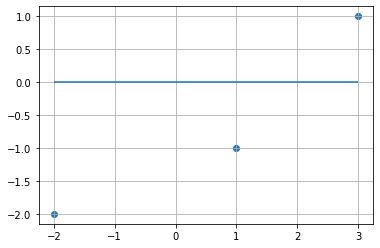

In [4]:
plt.scatter(pts[:,0],pts[:,1])
plt.hlines(0, -2, 3)
plt.grid(True)
plt.show()

Instead of y = mx + b, we just use y = mx, so that we can visualize R2 and SSR as slope changes

In [5]:
slope = np.linspace(-2,2,200)
ys = np.concatenate([np.atleast_2d(slope * pts[i,0]).T for i in range(3)], axis=1).T

In [6]:
sst = np.square(pts[:,1]).sum()

In [7]:
sst

6

In [8]:
ssr = np.array([np.square(ys[:,i] - pts[:,1]).sum() for i in range(ys.shape[1])])

In [9]:
r2 = 1 - ssr/sst

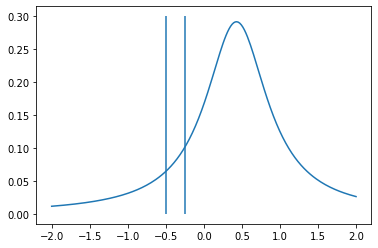

In [13]:
plt.plot(slope, 1/ssr)
plt.vlines([-.5,-.25], ymin=0, ymax=.3)
plt.show()

## MCMC

In [34]:
slope = -2
slope_history = np.zeros(1000)
slope_history[0] = slope

y = slope * pts[:,0]
sst = 6
ssr = np.square(y - pts[:,1]).sum()
ssr_history = np.zeros(1000)
ssr_history[0] = ssr

drift = lambda : np.random.normal(scale=.25)

accept = False

In [35]:
for i in range(1,1000):

    # Make slope wander
    slope = slope_history[i-1] + drift()
    y = slope * pts[:,0]
    ssr = np.square(y - pts[:,1]).sum()

    # if current ssr is less then the previous ssr, accept and continue
    if ssr > ssr_history[i-1]:
        p = ssr_history[i-1]/ssr # The current SSR's "power" relative to the previous one
        accept = np.random.choice([True, False], p=[p, 1-p])
        if not accept: # If we do not accept, we go to the beginning and try again
            slope_history[i] = slope_history[i-1]
            ssr_history[i] = ssr_history[i-1]
            continue

    # If we pass all the tests, record all the results and move on the next step
    slope_history[i] = slope
    ssr_history[i] = ssr

In [36]:
p, 1-p

(0.4673762111582019, 0.5326237888417982)

In [37]:
ssr

9.492098034140728

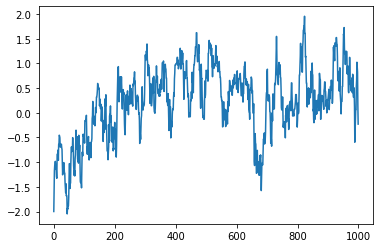

In [38]:
plt.plot(slope_history)

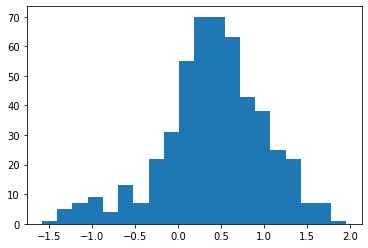

In [39]:
plt.hist(slope_history[500:], bins=20)
plt.show()

In [40]:
np.median(slope_history)

0.3184463044546511

# PyMC3

In [21]:
import pymc3 as pm

X, y = pts[:,0], pts[:,1]
with pm.Model() as linear_model:
    weights = pm.Normal("weights", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X @ weights,
        sigma=noise,
        observed=y,
    )

    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

<ipython-input-21-a1eb94324337>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise, weights]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7133518846410769, but should be close to 0.8. Try to increase the number of tuning steps.


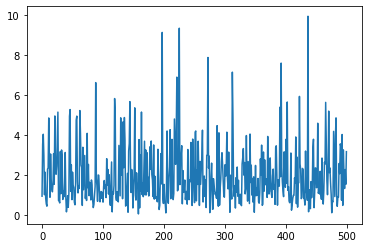

In [23]:
plt.plot(prior['noise'])

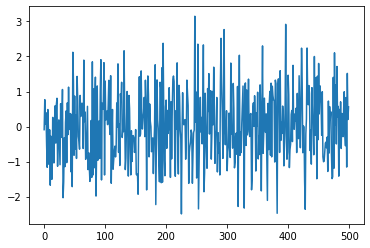

In [24]:
plt.plot(prior['weights'])

(array([155., 163.,  83.,  51.,  28.,  12.,   2.,   3.,   0.,   3.]),
 array([0.06716536, 1.05624691, 2.04532845, 3.03440999, 4.02349153,
        5.01257308, 6.00165462, 6.99073616, 7.97981771, 8.96889925,
        9.95798079]),
 <BarContainer object of 10 artists>)

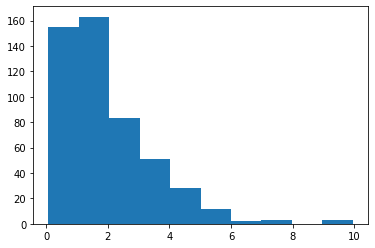

In [25]:
plt.hist(prior['noise'])

(array([ 11.,  34.,  64.,  90., 102.,  98.,  68.,  19.,  11.,   3.]),
 array([-2.49335519, -1.92920587, -1.36505656, -0.80090724, -0.23675793,
         0.32739139,  0.8915407 ,  1.45569002,  2.01983933,  2.58398865,
         3.14813797]),
 <BarContainer object of 10 artists>)

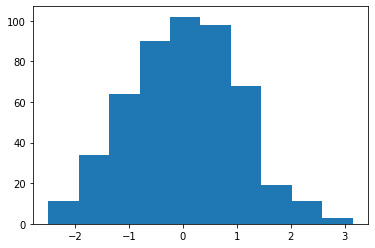

In [26]:
plt.hist(prior['weights'])

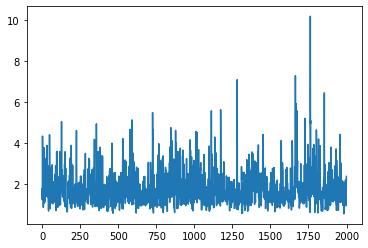

In [28]:
plt.plot(posterior['noise'])

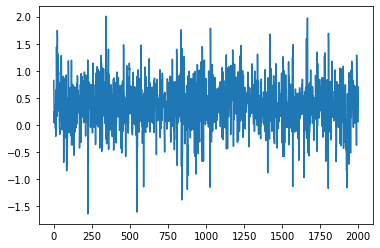

In [29]:
plt.plot(posterior['weights'])

(array([952., 743., 209.,  66.,  20.,   5.,   4.,   0.,   0.,   1.]),
 array([ 0.55580479,  1.52099354,  2.4861823 ,  3.45137106,  4.41655981,
         5.38174857,  6.34693733,  7.31212608,  8.27731484,  9.2425036 ,
        10.20769236]),
 <BarContainer object of 10 artists>)

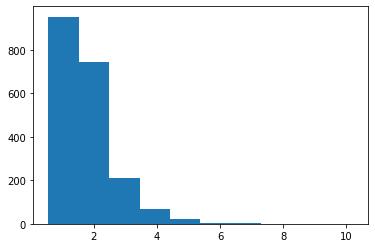

In [30]:
plt.hist(posterior['noise'])

(array([  4.,  10.,  37., 128., 424., 763., 471., 123.,  29.,  11.]),
 array([-1.63908078, -1.27453999, -0.90999919, -0.54545839, -0.1809176 ,
         0.1836232 ,  0.548164  ,  0.9127048 ,  1.27724559,  1.64178639,
         2.00632719]),
 <BarContainer object of 10 artists>)

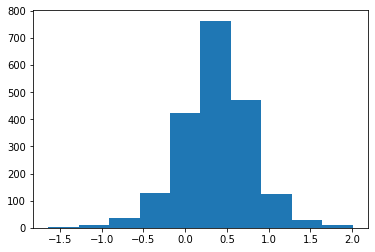

In [31]:
plt.hist(posterior['weights'])

In [32]:
np.median(posterior['weights'])

0.3980271214250416